In [160]:
%matplotlib inline
import geopandas as gp
import glob
import os
import sys
from os.path import dirname
parent_dir = dirname(dirname(os.getcwd()))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','2_hillslope_discharge'))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','3_channel_routing'))

from vadoseZone import *
from groundwaterZone import *
from REW import REW
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pickle
import vincent
from datetime import date
import pandas as pd
import numpy as np
import time
import sys
import shapely
import fiona
from pyDOE import *
import folium
from ast import literal_eval as make_tuple
from shapely.geometry import MultiLineString
import mpld3

# Load config files, forcing file, and paramters for each group
parent_dir = os.path.dirname(os.path.dirname(os.getcwd()))

# These dictionaries contain the all the data we'll need to instantiate 
rew_config = pickle.load( open( os.path.join(parent_dir,'model_data','rew_config.p'), "rb" ) )
climate_group_forcing = pickle.load( open( os.path.join(parent_dir,'model_data','climate_group_forcing.p'), "rb" ) )
parameter_group_params = pickle.load( open( os.path.join(parent_dir,'model_data','parameter_group_params.p'), "rb" ))
model_config = pickle.load( open( os.path.join(parent_dir, 'model_data', 'model_config.p'), 'rb'))
parameter_ranges = pickle.load( open( os.path.join(parent_dir, 'model_data', 'parameter_ranges.p'), 'rb'))

start_date = model_config['start_date']
stop_date = model_config['stop_date']
spinup_date = model_config['spinup_date']
Tmax = model_config['Tmax']
dt = model_config['dt_hillslope']
t = model_config['t_hillslope']
resample_freq_hillslope = model_config['resample_freq_hillslope']
timestamps_hillslope = model_config['timestamps_hillslope']

# Plot basins along with stream network

/Users/daviddralle/anaconda2/envs/py2k_gis/lib/python2.7/site-packages/dateutil/rrule.py:470: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)
/Users/daviddralle/anaconda2/envs/py2k_gis/lib/python2.7/site-packages/dateutil/rrule.py:470: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)
/Users/daviddralle/anaconda2/envs/py2k_gis/lib/python2.7/site-packages/dateutil/rrule.py:470: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)
/Users/daviddralle/anaconda2/envs/py2k_gis/lib/python2.7/site-packages/dateutil/rrule.py:470: DeprecationWarning: Using both 'coun

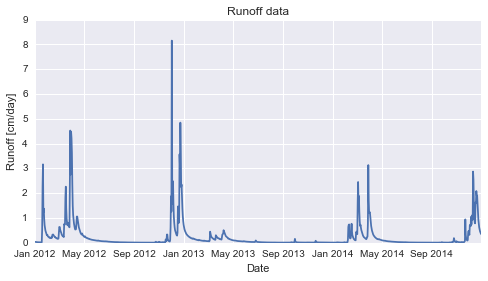

In [181]:
basins_file = glob.glob(os.path.join(parent_dir,'raw_data','basins_poly','*.shp'))[0]
basins_shape = gp.GeoDataFrame.from_file(basins_file)
basins_shape['coords'] = basins_shape['geometry'].apply(lambda x: x.representative_point().coords[:])
basins_shape['coords'] = [coords[0] for coords in basins_shape['coords']]
basins = basins_shape.to_crs(epsg='4326').to_json()

streams = glob.glob(os.path.join(parent_dir,'raw_data','streams_poly','*.shp'))[0]
streams_shape = gp.GeoDataFrame.from_file(streams).to_crs(epsg='4326')

mapa = folium.Map([basins_shape['coords'][0][1], basins_shape['coords'][0][0]],
                  zoom_start=11,
                  tiles='Stamen Terrain')

# cmap = sns.cubehelix_palette(light=1, as_cmap=True)
# hex_colors = []
# for i in range(cmap.N):
#     rgb = cmap(i)[:3]
#     hex_colors.append(matplotlib.colors.rgb2hex(rgb))

# hex_colors = hex_colors[0:]

folium.GeoJson(
    basins,
    style_function=lambda feature: {
        'color' : '#FF0000'
        }
    ).add_to(mapa)


for index, row in basins_shape.iterrows():
    rew_id = row['cat']
    label = 'REW ' + str(rew_id)
    folium.Marker([row['coords'][1], row['coords'][0]], popup=label).add_to(mapa)

streams = gp.GeoDataFrame(streams_shape['geometry'], crs=streams_shape.crs)
streams['RGBA'] = '#0000ff'
streams = streams.to_crs(epsg='4326').to_json()

colors = []
folium.GeoJson(
    streams,
    style_function=lambda feature: {
        'color' : feature['properties']['RGBA'],
        'weight' : 4, 
        'opacity': 1
        }
    ).add_to(mapa)


calibration_data_filename = 'elder_runoff.p'
calibration_data = pickle.load( open(os.path.join(parent_dir,'calibration_data',calibration_data_filename)))
calibration_data = calibration_data['2012':'2014']
fig = plt.figure(figsize=(8,4))
plt.plot(calibration_data)
plt.xlabel('Date')
plt.ylabel('Runoff [cm/day]')
plt.title('Runoff data')

html = mpld3.fig_to_html(fig)

iframe = folium.element.IFrame(html=html, width=650, height=400)
popup = folium.Popup(iframe, max_width=2650)
folium.Marker([basins_shape['coords'][0][1], basins_shape['coords'][0][0]], popup=popup).add_to(mapa)

mapa.save('test.html')




In [182]:
mv test.html /Users/daviddralle/Desktop/